In [15]:
# This allows multiple outputs from a single jupyter notebook cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [16]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import import_ipynb
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
import time
import abc

from data import TDDataFetcher

import mplfinance as mpf
# import ruptures as rpt

In [17]:
class Asset(metaclass=abc.ABCMeta):
    """
        Abstract base cass for representing a purchased 
    """
    def __init__(self):
        pass
    
class Stock(Asset):
    def __init__(self, ticker : str, data : pd.DataFrame, purchased : datetime):
        super(Stock, self).__init__()
        self.ticker = ticker
        self.data = data
        self._data_start_date = self.data.index[0]
        self._data_end_date = self.data.index[-1]
        self.purchased = purchased

class Portfolio(): 
    def __init__(self, assets : [Asset]):
        self.assets = assets

In [30]:
class AssetModel(metaclass=abc.ABCMeta):
    """
        Abstract base cass for representing an asset (with theoretical value)
    """
    def __init__(self):
        pass
    
class ChartableSecurity(metaclass=abc.ABCMeta):
    def __init__(self, data):
        self.data = data
        self.date_str = datetime.strptime(str(data.index[0]), '%Y-%m-%d %H:%M:%S').strftime('%m/%d/%y') + ' - ' + datetime.strptime(str(data.index[-1]), '%Y-%m-%d %H:%M:%S').strftime('%m/%d/%y')
        self.__mav_colors = mavcolors=['Blue','Orange','Magenta','Brown','Grey']
        self.__style = mpf.make_mpf_style(base_mpf_style='yahoo', y_on_right=False, edgecolor='Black', facecolor='White', mavcolors=self.__mav_colors)
        
    def _plot(self, data, type_name='candle', desc='', apds=[], mav=[], hlines=[],colors=['g','r'],linestyle='-.'):
        add_plots=[]
#         add_plots = [mpf.make_addplot(self.__add_mav(avg),linestyle='solid') for avg in mav]
#         apds.append(add_plots)
        fig, axs = mpf.plot(data, addplot=add_plots, figscale=1, figratio=(2*8,2*5.75), type=type_name, volume=True, hlines=hlines, style=self.__style, title='\n\n%s %s\n%s' % (self.__name__(), desc, self.date_str), returnfig=True)
        
        for avg in mav:
            axs[0].plot(np.arange(len(data.index)), self.__add_mav(avg))
            
        return fig, axs
    
    def plot_close_price(self, mav=[]): 
        fig, axs = self._plot(self.data, desc='Close Price', type_name='line', mav=mav, hlines=[250,300])
        return fig, axs
        
    def plot_candlesticks(self, mav=[]):            
        fig, axs = self._plot(self.data, type_name='candle', mav=mav)
        return fig, axs
        
    def plot_ohlc(self, mav=[]):
        fig, axs = self._plot(self.data, type_name='ohlc', mav=mav)
        return fig, axs
        
    def __add_mav(self, time_frame : int):
        if not 'MA%d' % time_frame in self.data:
            self.data.insert(len(self.data.columns),'MA%d' % time_frame, 0)
            self.data['MA%d' % time_frame] = self.data['Close'].rolling(time_frame).mean()
            
        return self.data['MA%d' % time_frame].values
        
#     def plot_renko(self): # TODO
#         fig, axs = self._plot(self.data, desc='(Renko)', type_name='renko')

    def plot_prediction(self, prediction, summary=False, type_name='line', desc='Prediction', adps=[], mavs=[]):
        index = self.data.index.append(prediction.index)
        prediction = pd.DataFrame(prediction, index=index)
        final_observed = aapl.data.iloc[-1]
        prediction.loc[final_observed.name] = final_observed['Close']
        
        if summary:            
            add_plots = [mpf.make_addplot(prediction.mean(axis=1),linestyle='solid'),
                mpf.make_addplot(prediction.max(axis=1),linestyle='solid'),
                mpf.make_addplot(prediction.min(axis=1),linestyle='solid')
            ]
        else:
            add_plots = [mpf.make_addplot(prediction[path],linestyle='solid') for path in prediction]

        data_trans = pd.DataFrame(self.data, index=index)
        fig, axs = mpf.plot(data_trans, addplot=add_plots, figscale=1, figratio=(2*8,2*5.75), type=type_name, volume=False, style=self.__style, title='\n\n%s %s\n%s' % (self.__name__(), desc, self.date_str), returnfig=True)
                
        
    @abc.abstractproperty
    def __name__(self):
        pass



In [31]:
class StockModel(AssetModel, ChartableSecurity):
    def __init__(self, ticker : str, data : pd.DataFrame):
        AssetModel.__init__(self)
        ChartableSecurity.__init__(self, data)
        self.ticker = ticker
        self._data_start_date = self.data.index[0]
        self._data_end_date = self.data.index[-1]
        self.data.insert(len(self.data.columns),'Return', 0)
        self.data['Return'] = self.data['Close'].pct_change()

    def __name__(self):
        return self.ticker
        
    def __str__(self):
        return self.ticker + ":\n" + str(self.data)
    
    def predict_GBM(self, T, dt=1, M=1):
        """
        Parameters:
            T --> time horizon in days
            dt --> time increment (defaults to 1 day)
            M --> # of paths to simulate
        """
        S0 = self.data.iloc[0]['Close']
        St = self.data.iloc[-1]['Close']
        mu = np.mean(self.data["Return"])
        sigma = np.std(self.data['Return'])
        
        N = T / dt
        indicies = pd.date_range(start=self.data.iloc[-1].name + timedelta(days=1), end=self.data.iloc[-1].name + timedelta(days=N), freq='D').map(lambda x : x if x.isoweekday() in range (1,6) else np.nan).dropna()
        N = len(indicies)
        
        drift = (mu - .5 * sigma * sigma)
        logS0 = np.log(St)
        
        df = pd.DataFrame(np.nan, columns=[], index=indicies)

        for i in range(M):
            
            logS = logS0
            diffusion = sigma * np.sqrt(dt)
            pred = np.empty(int(N))

            for j in range(int(N)):
                logS = logS + drift * dt + diffusion * np.random.normal(0,1)
                pred[j] = np.exp(logS)
                
            df.insert(len(df.columns),'Path%d' % (i+1), pred)
        
        return df

In [32]:
class Basket(metaclass=abc.ABCMeta): 
    def __init__(self, assets : [AssetModel]):
        self.assets = assets
        
    def __str__(self):
        string = ""
        for asset in self.assets:
            string += str(asset) + "\n\n\n"
        return string
    
class AssetGenerator(metaclass=abc.ABCMeta):
    """
        Abstract base cass for representing an asset
    """
    def __init__(self):
        pass

# TODO : Make StockGenerator and generalize to StockLoader
class StockFetcher(AssetGenerator):
    def __init__(self, data_gen): # TODO : generalized to DataLoader then DataGenerator
        super(StockFetcher, self).__init__()
        self.tickers = data_gen.get_tickers()
        self.data_gen = data_gen 
             
    # TODO : note that data_gen holds on to data after returns
    
    def get_historic_daily_quotes(self, start_date : datetime, end_date=date.today()):
        self.data_gen.get_daily_price_history(start_date, end_date)        
        return Basket([StockModel(ticker, self.data_gen.get_data_for(ticker)) for ticker in self.tickers])
            
    def get_historic_monthly_quotes(self, start_date : datetime, end_date=date.today()):
        self.data_gen.get_daily_price_history(start_date, end_date)        
        return Basket([StockModel(ticker, self.data_gen.get_data_for(ticker)) for ticker in self.tickers])
    
    def get_historic_yearly_quotes(self, start_date : datetime, end_date=date.today()):
        self.data_gen.get_yearly_price_history(start_date, end_date)        
        return Basket([StockModel(ticker, self.data_gen.get_data_for(ticker)) for ticker in self.tickers])

/Users/jfeibs/Desktop/stockalyzer/venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


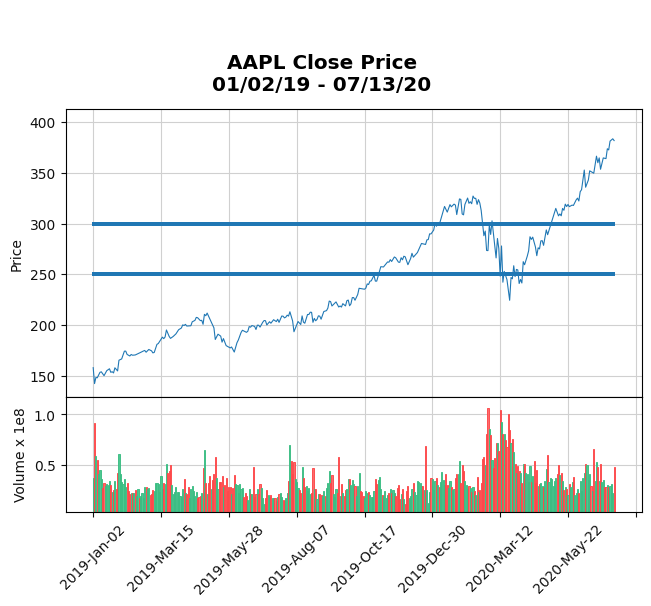

In [33]:
aapl = StockFetcher(TDDataFetcher(['AAPL'])).get_historic_daily_quotes(datetime(2019, 1, 1)).assets[0]
# pred = aapl.predict_GBM(100, M=1000)
# aapl.plot_prediction(pred, summary=True)
fig, axs = aapl.plot_close_price()
    